In [ ]:
#default_exp medical.imaging_roi

# Medical Imaging ROI Contour Extension

> Helpers for preparing datasets with ROI Contour files. Official dicom documentation can be found in [here](http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_C.8.html#sect_C.8.8.6)

In [ ]:
#export
from local.test import *
from local.basics import *
# from local.vision.all import *

from local.medical.imaging import *

In [ ]:
pd.options.display.max_columns = 20
pd.options.display.max_rows = 100

Here we have a parent directory which contains study subfolders. For using the helpers implemented in this notebook there is no assumption on how you store your data as long as it's possible to get all the dicom files. The reason behind this is associations between dependent dicom files are made using metadata not a predefined folder structure. Read more on DICOM studies [here](https://dcm4che.atlassian.net/wiki/spaces/d2/pages/1835038/A+Very+Basic+DICOM+Introduction)

In [ ]:
ATLAS_PATH = Path("/data/public/PICARE_BMETS_Raw_DICOM_Files"); len(ATLAS_PATH.ls())

250

In [ ]:
# 250 studies
ATLAS_PATH.ls()

(#250) [/data/public/PICARE_BMETS_Raw_DICOM_Files/1999-02__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2014-08__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2015-07__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2012-04__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2011-05__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2016-11__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2015-02__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2008-03__Studies,/data/public/PICARE_BMETS_Raw_DICOM_Files/2001-11__Studies...]

In [ ]:
# Let's grab a sample study folder
STUDY = ATLAS_PATH.ls()[5]

In [ ]:
# There are 10 folders inside this study directory
list(STUDY.ls())

[PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_228.9366_RTst_2005-08-01_000000_._MR.Bias.Corrected,.t-1.p.g-_n1__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_943.1428_MR_2005-08-09_000000_._MR.Bias.Corrected,.T1.axial.gad_n50__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_760.1202_RTst_2005-08-21_000000_._MR.Bias.Corrected,.ax.t1_n1__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_228.9366_MR_2005-08-01_000000_._MR.Bias.Corrected,.t-1.p.g-_n48__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_619.7806_MR_2005-08-10_000000_._MR.Bias.Corrected,.t-1.pg_n50__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_619.7806_RTst_2005-08-10_000000_._MR.Bias.Corrected,.t-1.pg_n1__00000'),
 PosixPath('/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.

### get files

In [ ]:
# Let's get all the dicom files recursively
dcm_files = get_files(STUDY, extensions=['.dcm'])

What we know during this analysis is that we not only have scan images but also ROI Contour files somewhere in our folders. For example, these ROI Contour files can allow us to create masks for supervised learning.

In [ ]:
# There are total of 256 dicom files
dcm_files

(#256) [/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_228.9366_RTst_2005-08-01_000000_._MR.Bias.Corrected,.t-1.p.g-_n1__00000/2.16.840.1.114362.1.11785856.22571270702.502850840.211.149.dcm,/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_943.1428_MR_2005-08-09_000000_._MR.Bias.Corrected,.T1.axial.gad_n50__00000/2.16.840.1.114362.1.11785856.22571269499.502850791.1016.112.dcm,/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_943.1428_MR_2005-08-09_000000_._MR.Bias.Corrected,.T1.axial.gad_n50__00000/2.16.840.1.114362.1.11785856.22571269499.502850791.1054.126.dcm,/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_943.1428_MR_2005-08-09_000000_._MR.Bias.Corrected,.T1.axial.gad_n50__00000/2.16.840.1.114362.1.11785856.22571269499.502850791.213.139.dcm,/data/public/PICARE_BMETS_Raw_DICOM_Files/2005-08__Studies/2.16.840_943.1428_MR_2005-08-09_000000_._MR.Bias.Corrected,.T1.axial.gad_n50__00000/2.16.840.1.114362.1.117858

### dicom namespaces

Here let's define namespaces for dicom tags and modalities. This will allow more readable and robust code.

In [ ]:
#export
dicom_tags = types.SimpleNamespace(
    # common
    modality = (0x0008,0x0060),
    study_instance_uid = (0x0020, 0x000d),
    sop_instance_uid = (0x0008, 0x0018),
    
    
    # MR pixel array conversion
    window_center = (0x0028, 0x1050),
    window_width = (0x0028, 0x1051),
    
    # for contour data mapping and extraction 
    roi_structure_sequence = (0x3006,0x0020),
    roi_contour_sequence = (0x3006, 0x0039),
    roi_number = (0x3006,0x0022),
    roi_name = (0x3006, 0x0026),
    referenced_roi_number = (0x3006, 0x0084),
    contour_sequence = (0x3006, 0x0040),
    contour_image_sequence = (0x3006, 0x0016),
    contour_frame_refid = (0x0008, 0x1155),
    contour_data = (0x3006, 0x0050),
    
    # contour to pixel position conversion
    pixel_spacing = (0x0028,0x0030),
    image_orientation = (0x0020,0x0037),
    image_position = (0x0020,0x0032),
    slice_thickness = (0x0018, 0x0050),
    slice_location = (0x0020,0x1041),
    anatomical_orientation = (0x0010,0x2210) 
)

dicom_modality = types.SimpleNamespace(
    # can be extended 
    ct = "CT",
    mr = "MR",
    rtstruct = "RTSTRUCT"
)

In [ ]:
# Let's read all the dcm files
dcm_datasets = L([o.dcmread() for o in dcm_files]); len(dcm_datasets)

256

### modality

Dicom datasets can have different modalities such as MR, CT, RTSTRUCT, ... Each modality may require special care during data preparation and processing. More on that [here](http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_C.8.html#sect_C.8.8.6)

In [ ]:
#export
@patch_property
def modality(self:DcmDataset):
    return self[dicom_tags.modality].value

### get dicom datasets for an instance

We will use dicom study instance uid to create two dictionaries; one for RTSTRUCT files and one for image files which can come in MR or CT modality. Mapping will be study instance to dcm files.

In [ ]:
struct_datasets, image_datasets = defaultdict(list), defaultdict(list)
for o in dcm_datasets: 
    if o.modality == dicom_modality.rtstruct: 
        struct_datasets[o[dicom_tags.study_instance_uid].value].append(o)
    elif o.modality in [dicom_modality.ct, dicom_modality.mr]: 
        image_datasets[o[dicom_tags.study_instance_uid].value].append(o)
    else: raise Exception(f"Unknown modality: {o.modality} in DcmDataset")

We see that there are 5 distinct studies in this collection of files. Usually a struct file will have ROI contour information for a unique study so we expect it to be a single file but there may be some edge cases that user should keep an eye open to.

In [ ]:
len(struct_datasets), len(image_datasets)

(5, 5)

In [ ]:
try: assert len(struct_datasets) == len(image_datasets)
except: raise Exception("Some study instances may not be present in either images or structs")

In [ ]:
# get a unique Study Instance UID
sid = list(struct_datasets.keys())[0]; sid

'2.16.840.1.114362.1.11782787.21988995044.495776816.228.9366'

Below we see that there is a single struct file as we usually expect and 48 image dcm files. Each image dcm file usually corresponds to a slice image of a 3D scan.

In [ ]:
# get struct and image dcm files for this study instance  
structs, images = struct_datasets[sid], image_datasets[sid]; len(structs), len(images)

(1, 48)

In the cases of multiple struct files user should choose which one to proceed with as there isn't usually 2 ground truths in our supervised learning pipeline.

In [ ]:
# Let's pick the only struct dataset present for the study instane
structds = structs[0]

### type dispatching for modalities

As we emphasized before different modalities require different care but we have a single class type for each modality which is `DcmDataset`. For now, we will handle type dispatching for methods and properties with a custom exception we create for `RTSTRUCT` modality. Later we can introduce new subclasses such as `DcmCTDataset`, `DcmMRDataset`, `DcmStructDataset` etc...

In [ ]:
#export
class NotStructTypeException(Exception):
    def __init__(self, modality): self.modality = modality  
    def __str__(self): return f"This method or property is only available for RTSTRUCT types, not for {self.modality}"

In [ ]:
print(NotStructTypeException("CT"))

This method or property is only available for RTSTRUCT types, not for CT


Each ROI has a name tag for understanding the context of the contour, they are usually different structural regions in human anatomy; such as `Brain`, `Tumor`, `Ventricle`, `Skull` and so on...

### contour methods and properties

In [ ]:
#export
@patch_property
def roi_names(self:DcmDataset):
    "return available ROI names for RTSTRUCT type DcmDatasets"
    if self.modality == dicom_modality.rtstruct:
        return {o[dicom_tags.roi_name].value for o in self[dicom_tags.roi_structure_sequence]}
    else: raise NotStructTypeException(self.modality)

In [ ]:
structds.roi_names

{'*Skull', 'Brain', 'Ventricles', 'target14', 'target15'}

In [ ]:
# Raise exception
imgds = images[0]; imgds.roi_names

NotStructTypeException: This method or property is only available for RTSTRUCT types

In [ ]:
#export
@patch
def contour_sequence(self:DcmDataset, roi_name):
    "return contour sequence for a given ROI by name"
    if self.modality == dicom_modality.rtstruct:
        for o in self[dicom_tags.roi_structure_sequence]:
            if o[dicom_tags.roi_name].value == roi_name: 
                roi_number = o[dicom_tags.roi_number].value
        for o in self[dicom_tags.roi_contour_sequence]:
            if o[dicom_tags.referenced_roi_number].value == roi_number: 
                return o[dicom_tags.contour_sequence]
    else: raise NotStructTypeException(self.modality)

We can call this method with any available ROI name in `DcmDataset.roi_names`. Each element in the sequence below has a reference in `images` of that study instance, or in other words a correspondance to a particular slice.

In [ ]:
brain_contour_seq = structds.contour_sequence("Ventricles"); brain_contour_seq

<Sequence, length 53>

In [ ]:
brain_contour_seq[0]

(3006, 0016)  Contour Image Sequence   1 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storage
   (0008, 1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.11785856.22571270702.502850838.561.125
   ---------
(3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
(3006, 0046) Number of Contour Points            IS: "86"
(3006, 0050) Contour Data                        DS: Array of 258 elements

In [ ]:
#export
@patch
def contour_refdict(self:DcmDataset, roi_name):
    "get dict of referenence frame id to x,y,z (mm) contour for a given ROI"
    if self.modality == dicom_modality.rtstruct:
        roi_contour_seq = self.contour_sequence(roi_name)
        d = defaultdict(list)
        for contour_ds in roi_contour_seq: 
            contour_data = contour_ds[dicom_tags.contour_data].value
            contour_img_sequence = list(contour_ds[dicom_tags.contour_image_sequence])
            try: assert len(contour_img_sequence) == 1
            except: raise Exception("""Contour Image Sequence doesn't have exactly one element,
                                    might have more instance references.""")
            refid = contour_img_sequence[0][dicom_tags.contour_frame_refid].value
            d[refid].append(contour_data)
        return d
    else: raise NotStructTypeException(self.modality)

Get contour data with reference id for a given ROI name. Contour data is in real world coordinate system (mm) and has `[x1,y1,z1,x2,y2,z2,...]` structure. One image slice can have multiple contour data. 

In [ ]:
contour_refdict = structds.contour_refdict("Brain"); next(iter(contour_refdict.items()))

('2.16.840.1.114362.1.11785856.22571270702.502850838.585.134',
 [['144.415', '129.445', '-8.981', '144.708', '129.151', '-8.981', '146.469', '129.151', '-8.981', '146.763', '129.445', '-8.981', '147.057', '129.738', '-8.981', '147.644', '129.738', '-8.981', '147.937', '130.032', '-8.981', '148.231', '130.326', '-8.981', '148.524', '130.619', '-8.981', '148.818', '130.913', '-8.981', '149.405', '130.913', '-8.981', '149.698', '131.206', '-8.981', '149.992', '131.5', '-8.981', '150.285', '131.793', '-8.981', '150.285', '132.38', '-8.981', '150.579', '132.674', '-8.981', '150.872', '132.967', '-8.981', '151.166', '133.261', '-8.981', '151.459', '133.554', '-8.981', '151.753', '133.848', '-8.981', '152.046', '134.141', '-8.981', '152.34', '134.435', '-8.981', '152.634', '134.728', '-8.981', '152.927', '135.022', '-8.981', '153.221', '135.315', '-8.981', '153.514', '135.609', '-8.981', '153.808', '135.903', '-8.981', '153.808', '136.49', '-8.981', '154.101', '136.783', '-8.981', '154.395', 

### generate masks

> There 4 types of contour data 

`POINT` - single point

`OPEN_PLANAR` - open contour containing coplanar points

`OPEN_NONPLANAR` - open contour containing non-coplanar points

`CLOSED_PLANAR` - closed contour (polygon) containing coplanar points

For `OPEN_PLANAR` or `CLOSED_PLANAR` contour data we can use `poly2mask` to generate a mask. For `POINT` no futher processing would be required.

TODO: `OPEN_NONPLANAR` requires more investigation and reading

In [ ]:
#export
from skimage import draw
def poly2mask(i, j, shape):
    "convert polygon coordinates to closed planar mask, can be floating vertices"
    row_coords, col_coords = draw.polygon(j, i, shape)
    mask = np.zeros(shape, dtype=np.int)
    mask[row_coords, col_coords] = 1
    return mask

In [ ]:
# #export
# @patch
# def contourdata2mask(self:DcmDataset, contourdata:DcmMultiValue): 
#     "A method for reference DcmDataset to convert real world x,y,z (mm) contour to pixel mask"
#     #http://dicom.nema.org/MEDICAL/dicom/2017b/output/chtml/part03/sect_C.7.6.2.html#sect_C.7.6.2.1.1
#     #no assumptions made directly use official formula
#     #How to partially solve sys of eqn. if part of b is known in b = Ax + b? (Any library have this?)
#     pixel_spacing = array(self[dicom_tags.pixel_spacing].value)[:,None]
#     image_orientation = array(self[dicom_tags.image_orientation].value).reshape(2,3)
#     image_position = array(self[dicom_tags.image_position].value)
#     M = np.vstack([image_orientation*pixel_spacing, image_position])[:2,:2]
#     contourdata = array(contourdata).reshape(-1,3)[:,:2]
#     ij = np.vstack([(array(np.linalg.solve(M, coord))) for coord in contourdata])
#     i,j = list(zip(*np.stack(ij)[:,:2]))
#     return poly2mask(i,j,self.shape)

In [ ]:
#export
@patch
def contourdata2mask(self:DcmDataset, contourdata:DcmMultiValue): 
    "A method for reference DcmDataset to convert real world x,y,z (mm) contour to pixel mask"
    pixel_spacing = array(self[dicom_tags.pixel_spacing].value)
    image_position = array(self[dicom_tags.image_position].value)
    cntdata = array(contourdata).reshape(-1,3)
    i,j = list(zip(*(cntdata[:,:2] - image_position[:2]) / (pixel_spacing)))
    return poly2mask(i,j,self.shape)

In [ ]:
# map reference instance ids to dcm image dataset
refid2imgds = {o[dicom_tags.sop_instance_uid].value:o for o in images}

In [ ]:
# map reference instance ids to generated mask
refid2masks = {}
for refid, contourdata in contour_refdict.items(): 
    refds = refid2imgds[refid]
    refid2masks[refid] = tensor(sum([refds.contourdata2mask(o) 
                                     for o in contourdata]).astype(np.uint8))

In [ ]:
# sort by instance number - field for sorting may or may not be different
images = sorted(images, key=lambda o: int(o['InstanceNumber'].value))

In [ ]:
# collate ordered image tensors
voxel_image = torch.stack([o.pixels for o in images]); voxel_image.shape

torch.Size([48, 256, 256])

In [ ]:
# collate oredered mask tensors, put zero tensor if mask is not present for a slice
voxel_mask = []
for imgds in images:
    refid = imgds[dicom_tags.sop_instance_uid].value
    if refid in refid2masks: voxel_mask += [refid2masks[refid]]
    else: voxel_mask += [torch.zeros(imgds.shape, dtype=torch.uint8)]
voxel_mask = torch.stack(voxel_mask); voxel_mask.shape

torch.Size([48, 256, 256])

### data inspection

It's important to check data if there are any inconsistencies. For example, masks may be flipped and might need further processing. 

Default assumption is: `If Anatomical Orientation Type (0010,2210) is absent or has a value of BIPED, the x-axis is increasing to the left hand side of the patient. The y-axis is increasing to the posterior side of the patient. The z-axis is increasing toward the head of the patient.`

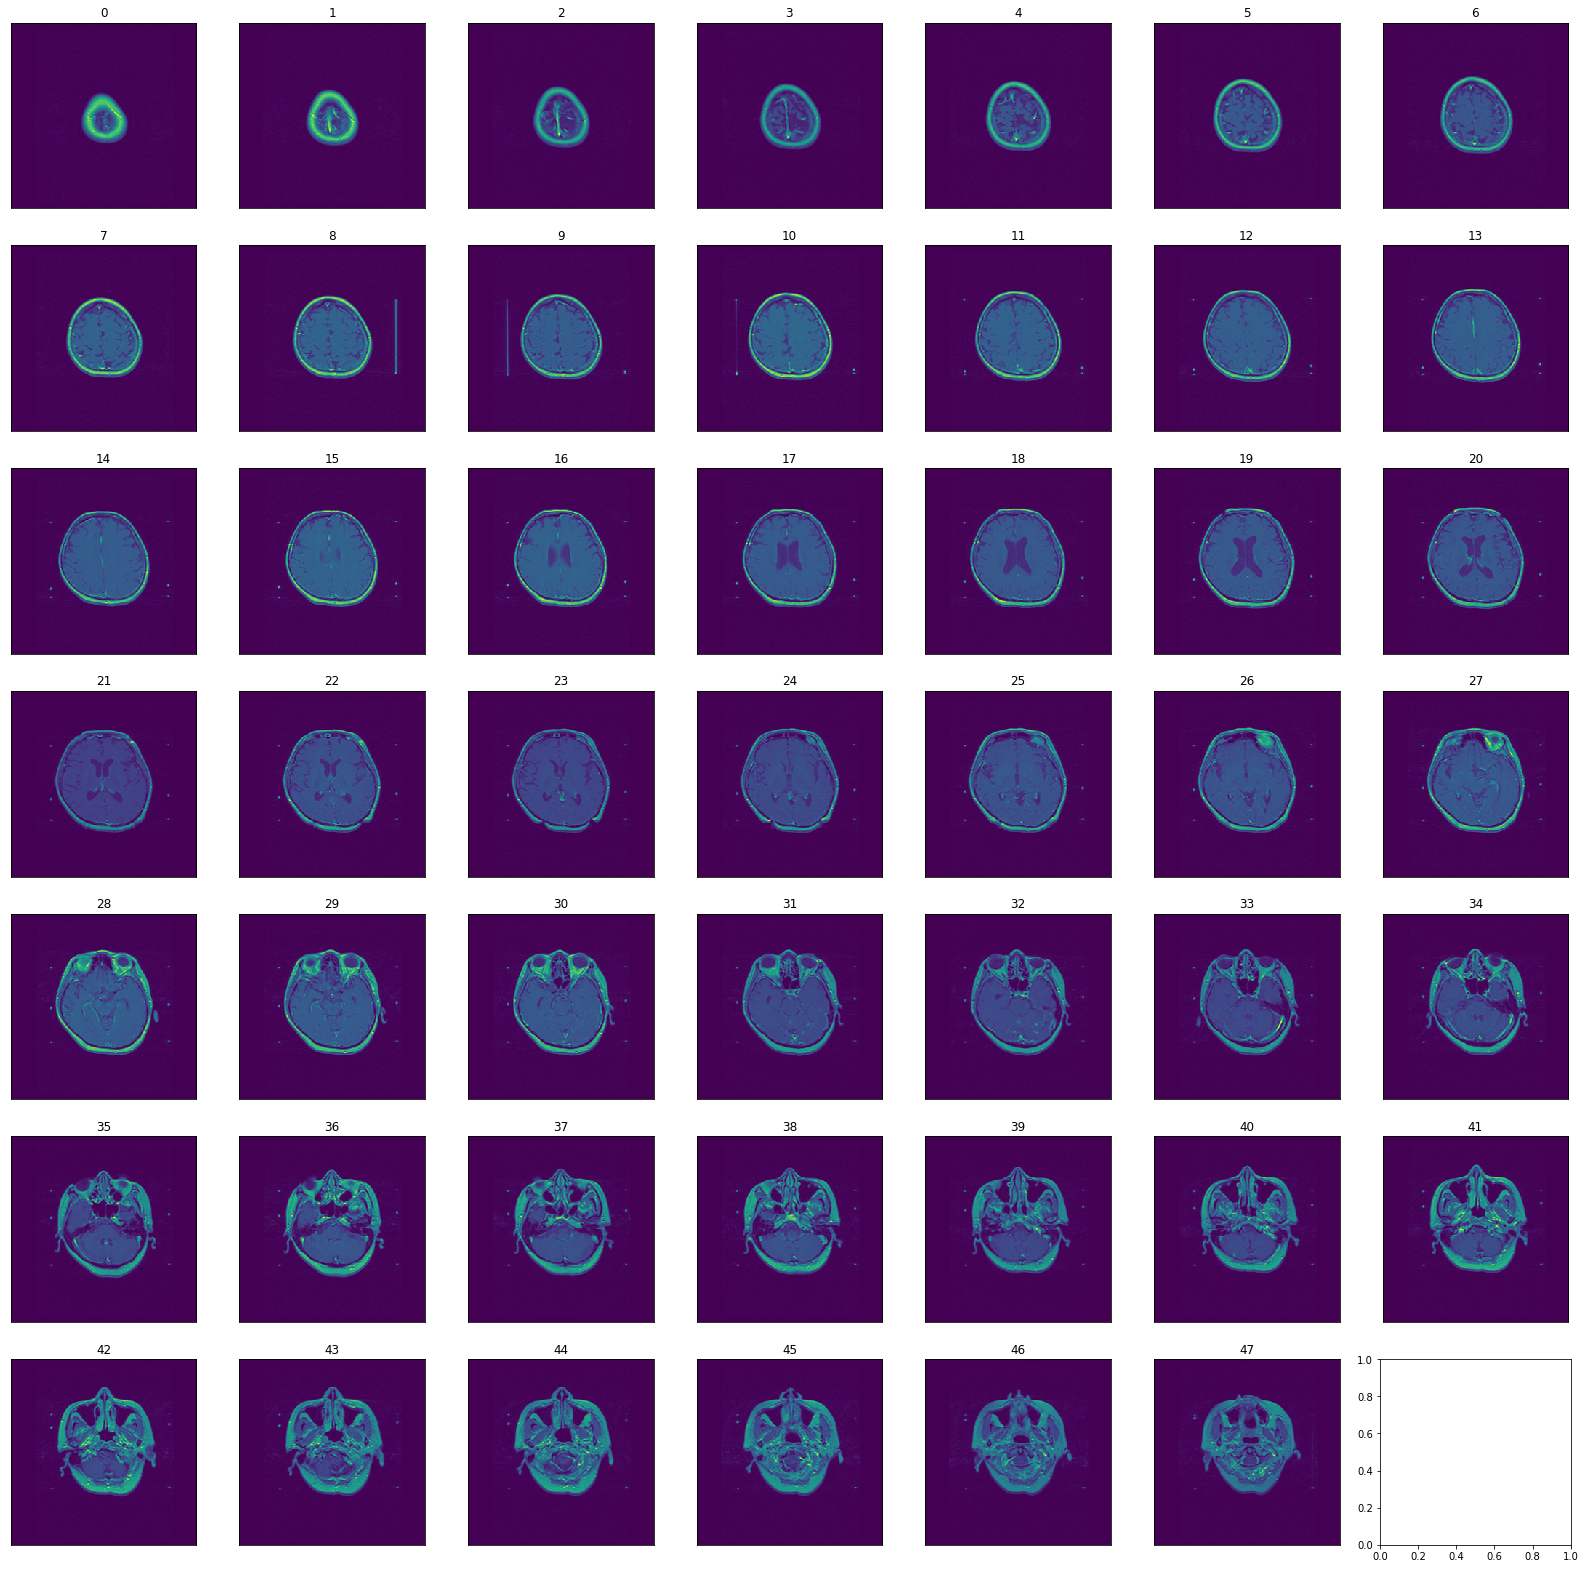

In [ ]:
n = int(np.ceil(np.sqrt(len(voxel_image))))
fig,axes = plt.subplots(n,n,figsize=(4*n,4*n))
for i,(arr,ax) in enumerate(zip(voxel_image,axes.flatten())): 
    ax.imshow(arr); ax.set_title(str(i)); ax.set_xticks([]); ax.set_yticks([])

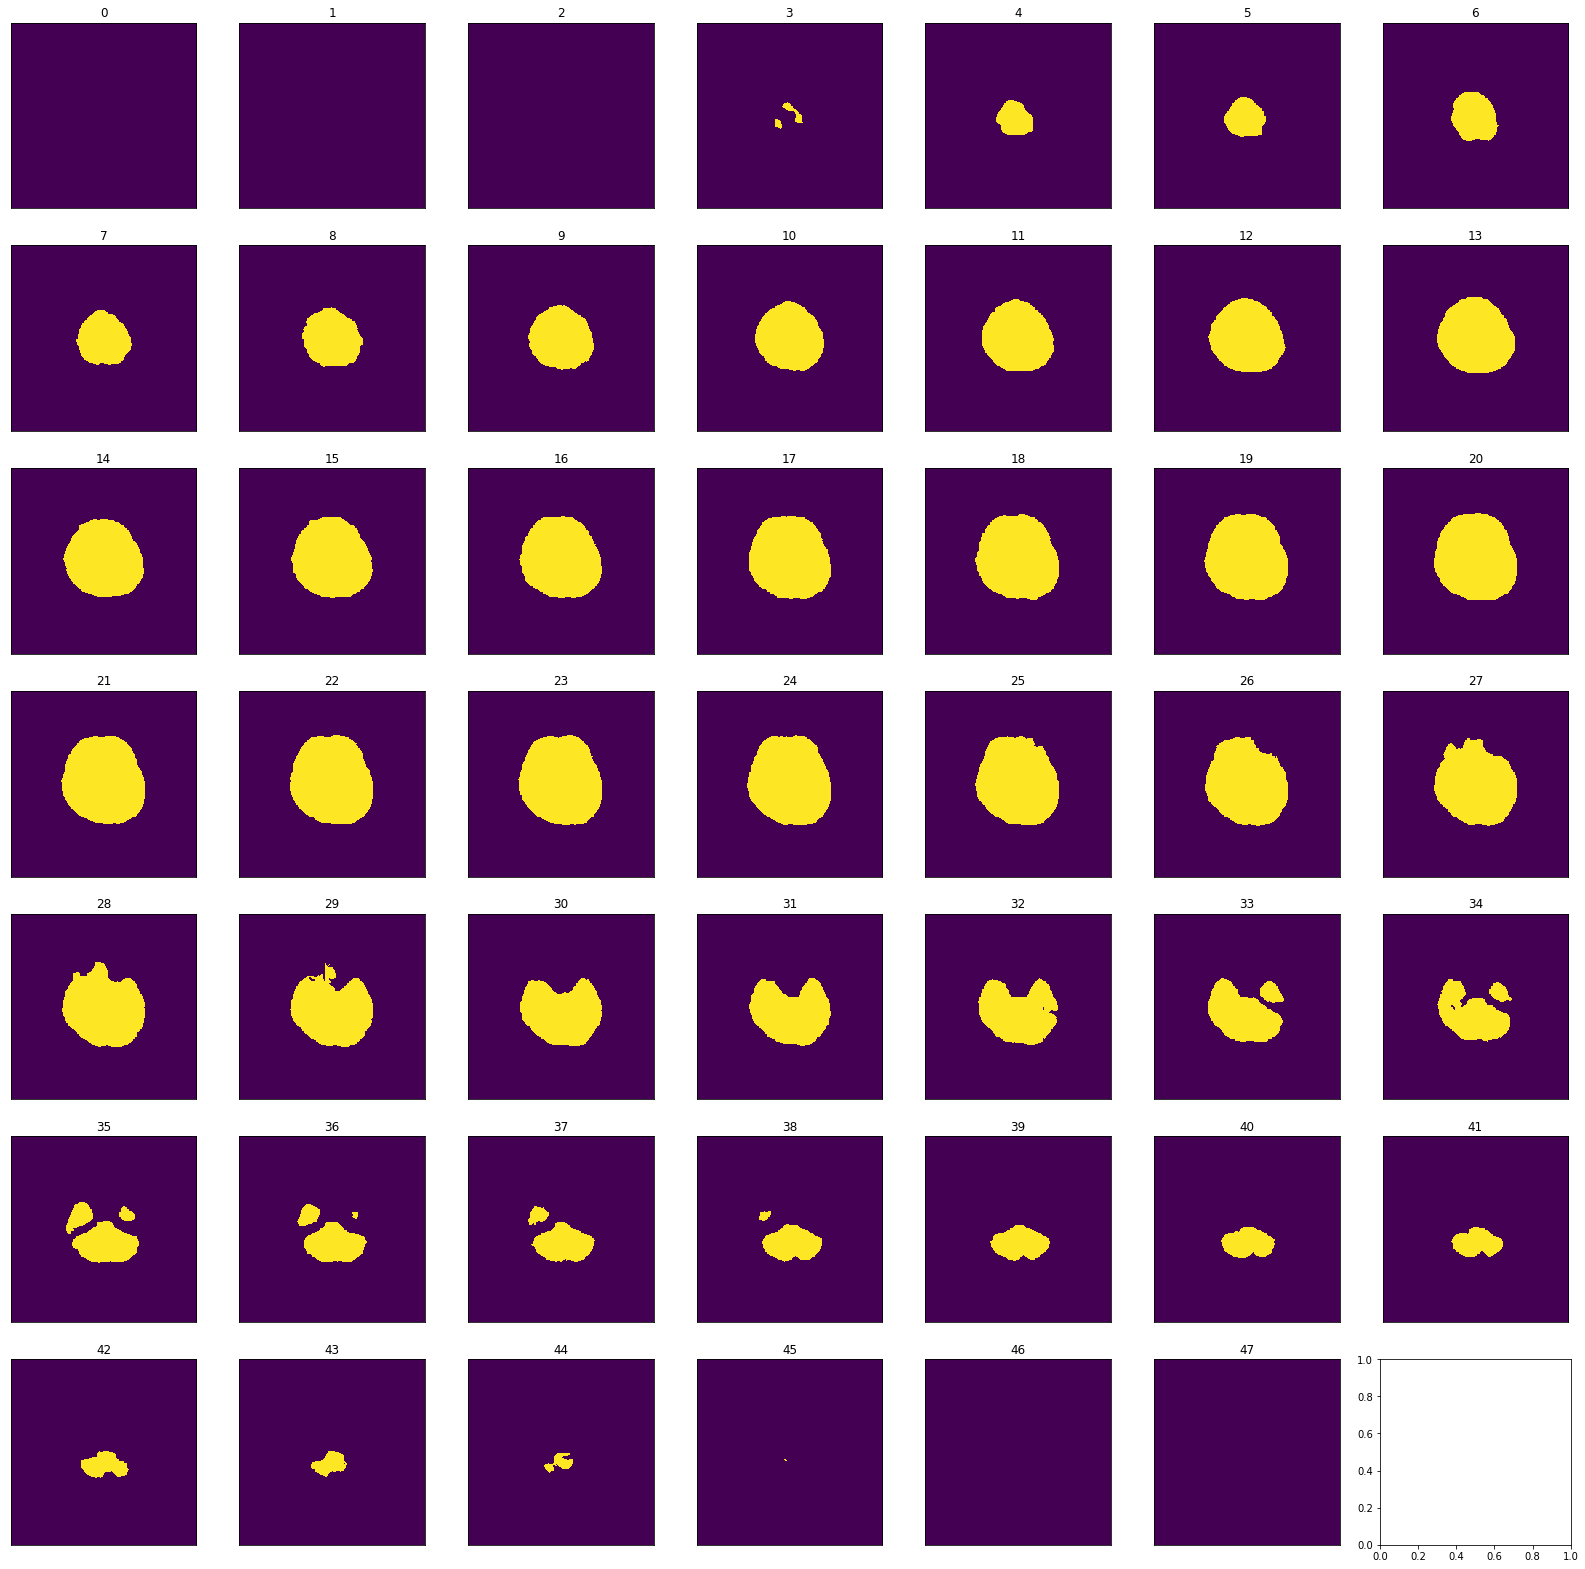

In [ ]:
n = int(np.ceil(np.sqrt(len(voxel_mask))))
fig,axes = plt.subplots(n,n,figsize=(4*n,4*n))
for i,(arr,ax) in enumerate(zip(voxel_mask,axes.flatten())): 
    ax.imshow(arr); ax.set_title(str(i)); ax.set_xticks([]); ax.set_yticks([])

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core_foundation.ipynb.
Converted 01a_core_utils.ipynb.
Converted 01b_core_dispatch.ipynb.
Converted 01c_core_transform.ipynb.
Converted 02_core_script.ipynb.
Converted 03_torchcore.ipynb.
Converted 03a_layers.ipynb.
Converted 04_data_load.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_vision_data.ipynb.
Converted 09b_vision_utils.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_interpret.ipynb.
C